
# <center> <a href="https://www.rug.nl/ggdc/productivity/pwt/">Working with Penn World Tables (PWT)</a></center>

<center><a href="https://www.rug.nl/ggdc/productivity/pwt/"> <img src="https://raw.githubusercontent.com/SMU-Econ-Growth/EconGrowthUG-Notebooks/main/pics/pwt_logo.png" alt="PWT" width=500/></a>  </center>

* PWT is a database with information on relative levels of income, output, input and productivity, covering 183 countries between 1950 and 2019. 

* Widely used for analysis

* Free and easy to access

* Includes variables not available in many other databases, capital stocks, total factor productivities, price indices, etc.

* If you check [their website](https://www.rug.nl/ggdc/productivity/pwt/) you can see more information on them, also identify and search the variables you may want to focus on. 

# Setup

# Import Modules and set Paths

In [1]:
# Basic Packages
from __future__ import division
import os
from datetime import datetime

# Web & file access
import requests
import io

# Import display options for showing websites
from IPython.display import IFrame, HTML

In [2]:
# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

%pylab --no-import-all
%matplotlib inline

import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_context("talk")

import plotly.express as px
import plotly.graph_objects as go

from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap
# Next line can import all of plotnine, but may overwrite things? Better import each function/object you need
#from plotnine import *

Using matplotlib backend: <object object at 0x7febcbe09c90>
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
# Data
import pandas as pd
import numpy as np
from pandas_datareader import data, wb

# GIS & maps
import geopandas as gpd
gp = gpd
import georasters as gr
import geoplot as gplt
import geoplot.crs as gcrs
import mapclassify as mc
import textwrap

/tmp/ipykernel_91/2949915091.py:7: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
/opt/conda/lib/python3.10/site-packages/libpysal/cg/alpha_shapes

In [4]:
# Data Munging
from itertools import product, combinations
import difflib
import pycountry
import geocoder
from geonamescache.mappers import country
mapper = country(from_key='name', to_key='iso3')
mapper2 = country(from_key='iso3', to_key='iso')
mapper3 = country(from_key='iso3', to_key='name')

# Regressions & Stats
from scipy.stats import norm
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer, LineLocation

In [5]:
# Paths
pathout = './data/'

if not os.path.exists(pathout):
    os.mkdir(pathout)
    
pathgraphs = './graphs/'
if not os.path.exists(pathgraphs):
    os.mkdir(pathgraphs)

In [6]:
currentYear = datetime.now().year
year = min(2019, currentYear-3)
year

2019

# Getting PWT data

# Downloading the data

## PWT has an [online data access tool](https://pwt-data-tool.streamlit.app/)

* May not be most efficient way to get data
* Great to see which variables are there (see below)

In [7]:
url = 'https://pwt-data-tool.streamlit.app/'
IFrame(url, width=800, height=400)

## Download the whole PWT dataset directly (it is a much smaller dataset than WDI)

* There are Stata and Excel versions, we will work with the Stata file 
    * Download data into dataframe `pwt`
    * Get labels so we know what variable each column is `pwt_labels`
```python
pwt_version = '100'
pwt = pd.read_stata('https://www.rug.nl/ggdc/docs/pwt' + pwt_version + '.dta')
pwt_labels = pd.io.stata.StataReader('https://www.rug.nl/ggdc/docs/pwt' + pwt_version + '.dta').variable_labels()
```

In [8]:
pwt_version = '100'
pwt = pd.read_stata('https://dataverse.nl/api/access/datafile/354098')#'https://www.rug.nl/ggdc/docs/pwt' + pwt_version + '.dta')
pwt_labels = pd.io.stata.StataReader('https://dataverse.nl/api/access/datafile/354098').variable_labels()

In [9]:
pwt.head()

countrycode country   currency_unit  year  rgdpe  rgdpo  pop  emp  avh  hc  \
0         ABW   Aruba  Aruban Guilder  1950    NaN    NaN  NaN  NaN  NaN NaN   
1         ABW   Aruba  Aruban Guilder  1951    NaN    NaN  NaN  NaN  NaN NaN   
2         ABW   Aruba  Aruban Guilder  1952    NaN    NaN  NaN  NaN  NaN NaN   
3         ABW   Aruba  Aruban Guilder  1953    NaN    NaN  NaN  NaN  NaN NaN   
4         ABW   Aruba  Aruban Guilder  1954    NaN    NaN  NaN  NaN  NaN NaN   

   ...  csh_x  csh_m  csh_r  pl_c  pl_i  pl_g  pl_x  pl_m  pl_n  pl_k  
0  ...    NaN    NaN    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1  ...    NaN    NaN    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2  ...    NaN    NaN    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
3  ...    NaN    NaN    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
4  ...    NaN    NaN    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[5 rows x 52 columns]

In [10]:
pwt_labels

{'countrycode': '3-letter ISO country code',
 'country': 'Country name',
 'currency_unit': 'Currency unit',
 'year': 'Year',
 'rgdpe': 'Expenditure-side real GDP at chained PPPs (in mil. 2017US$)',
 'rgdpo': 'Output-side real GDP at chained PPPs (in mil. 2017US$)',
 'pop': 'Population (in millions)',
 'emp': 'Number of persons engaged (in millions)',
 'avh': 'Average annual hours worked by persons engaged (source: The Conference Board)',
 'hc': 'Human capital index, see note hc',
 'ccon': 'Real consumption of households and government, at current PPPs (in mil. 2017US$)',
 'cda': 'Real domestic absorption, see note cda',
 'cgdpe': 'Expenditure-side real GDP at current PPPs (in mil. 2017US$)',
 'cgdpo': 'Output-side real GDP at current PPPs (in mil. 2017US$)',
 'cn': 'Capital stock at current PPPs (in mil. 2017US$)',
 'ck': 'Capital services levels at current PPPs (USA=1)',
 'ctfp': 'TFP level at current PPPs (USA=1)',
 'cwtfp': 'Welfare-relevant TFP levels at current PPPs (USA=1)',
 'rg

## Create some variables of interest

## Income per capita and its logarithm based on expenditures and outputs, i.e., the `rgdpe` and `rgdpo` variables

In [11]:
pwt['gdp_pc_e'] = pwt['rgdpe'] / pwt['pop']
pwt['gdp_pc_o'] = pwt['rgdpo'] / pwt['pop']
pwt['ln_gdp_pc_e'] = pwt['gdp_pc_e'].apply(np.log)
pwt['ln_gdp_pc_o'] = pwt['gdp_pc_o'].apply(np.log)
pwt['ln_pop'] = pwt['pop'].apply(np.log)

## Add some additional data to identify country groups, regions, etc.

In [12]:
wbcountries = wb.get_countries()
wbcountries['name'] = wbcountries.name.str.strip()
wbcountries = wbcountries.loc[wbcountries.region.isin(['Aggregates'])==False].reset_index(drop=True)
wbcountries['incomeLevel'] = wbcountries['incomeLevel'].str.title()
wbcountries.loc[wbcountries.iso3c=='VEN', 'incomeLevel'] = 'Upper Middle Income'

In [13]:
df = pwt.merge(wbcountries, left_on='countrycode', right_on='iso3c')
df.head()

countrycode country   currency_unit  year  rgdpe  rgdpo  pop  emp  avh  hc  \
0         ABW   Aruba  Aruban Guilder  1950    NaN    NaN  NaN  NaN  NaN NaN   
1         ABW   Aruba  Aruban Guilder  1951    NaN    NaN  NaN  NaN  NaN NaN   
2         ABW   Aruba  Aruban Guilder  1952    NaN    NaN  NaN  NaN  NaN NaN   
3         ABW   Aruba  Aruban Guilder  1953    NaN    NaN  NaN  NaN  NaN NaN   
4         ABW   Aruba  Aruban Guilder  1954    NaN    NaN  NaN  NaN  NaN NaN   

   ...  iso3c  iso2c   name                      region  adminregion  \
0  ...    ABW     AW  Aruba  Latin America & Caribbean                 
1  ...    ABW     AW  Aruba  Latin America & Caribbean                 
2  ...    ABW     AW  Aruba  Latin America & Caribbean                 
3  ...    ABW     AW  Aruba  Latin America & Caribbean                 
4  ...    ABW     AW  Aruba  Latin America & Caribbean                 

   incomeLevel     lendingType  capitalCity  longitude  latitude  
0  High Income  Not classified   Oranjestad   -70.0167   12.5167  
1  High Income  Not classified   Oranjestad   -70.0167   12.5167  
2  High Income  Not classified   Oranjestad   -70.0167   12.5167  
3  High Income  Not classified   Oranjestad   -70.0167   12.5167  
4  High Income  Not classified   Oranjestad   -70.0167   12.5167  

[5 rows x 67 columns]

# Regression Analysis with 
<center><a href="statsmodels"><img src="https://www.statsmodels.org/stable/_images/statsmodels-logo-v2-horizontal.svg" alt="statsmodels" width=700/></a></center>

In [14]:
url = 'https://www.statsmodels.org/stable/index.html'
IFrame(url, width=800, height=400)

## Linear Regressions using OLS 

It is very easy to run a regression in **statsmodels**. 

We only need

* Data in a **pandas** dataframe

* An equation we want to estimate

Equations are strings of the form 
```python
'dependent_variable ~ indep_var_1 + function(indep_var2) + C(indep_var3)'
```

where:
* `dependent_variable` is the outcome variable of interest
* `indep_var_1` is the first independent variable        
* `function(indep_var2)` is a function of another independent variable (if needed)      
* `C(indep_var3)` defines fixed-effects/dummies based on categories given in indep_var3

## Simple Regression of Log[GDP pc] and Log[Population]

In [15]:
dffig = df.loc[df.year==year]\
            .dropna(subset=['ln_gdp_pc_o', 'ln_gdp_pc_e', 'ln_pop'])\
            .sort_values(by=['region', 'iso3c']).reset_index(drop=True)
dffig.head()

countrycode               country      currency_unit  year         rgdpe  \
0         AUS             Australia  Australian Dollar  2019  1.280843e+06   
1         BRN     Brunei Darussalam      Brunei Dollar  2019  2.927074e+04   
2         CHN                 China      Yuan Renminbi  2019  2.005607e+07   
3         FJI                  Fiji        Fiji Dollar  2019  1.223546e+04   
4         HKG  China, Hong Kong SAR   Hong Kong Dollar  2019  4.405543e+05   

          rgdpo          pop         emp          avh        hc  ...  iso3c  \
0  1.364678e+06    25.203198   12.863174  1726.797659  3.549666  ...    AUS   
1  3.173777e+04     0.433285    0.222358          NaN  2.798208  ...    BRN   
2  2.025766e+07  1433.783686  798.807739  2168.918848  2.698987  ...    CHN   
3  1.224018e+04     0.889953    0.308248          NaN  2.701598  ...    FJI   
4  4.075758e+05     7.436154    3.863810  2147.574362  3.267884  ...    HKG   

   iso2c                  name               region  \
0     AU             Australia  East Asia & Pacific   
1     BN     Brunei Darussalam  East Asia & Pacific   
2     CN                 China  East Asia & Pacific   
3     FJ                  Fiji  East Asia & Pacific   
4     HK  Hong Kong SAR, China  East Asia & Pacific   

                                   adminregion          incomeLevel  \
0                                                       High Income   
1                                                       High Income   
2  East Asia & Pacific (excluding high income)  Upper Middle Income   
3  East Asia & Pacific (excluding high income)  Upper Middle Income   
4                                                       High Income   

      lendingType          capitalCity  longitude  latitude  
0  Not classified             Canberra    149.129 -35.28200  
1  Not classified  Bandar Seri Begawan    114.946   4.94199  
2            IBRD              Beijing    116.286  40.04950  
3           Blend                 Suva    178.399 -18.11490  
4  Not classified                         114.109  22.39640  

[5 rows x 67 columns]

## Simple Regression of Log[GDP pc] (Output based GDP) and Log[Population]

In [16]:
mod = smf.ols(formula='ln_gdp_pc_o ~ ln_pop', data=dffig, missing='drop').fit()

In [17]:
mod.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.042   
Dependent Variable: ln_gdp_pc_o      AIC:                564.1845
Date:               2024-10-28 15:48 BIC:                570.5704
No. Observations:   180              Log-Likelihood:     -280.09 
Df Model:           1                F-statistic:        8.847   
Df Residuals:       178              Prob (F-statistic): 0.00334 
R-squared:          0.047            Scale:              1.3303  
------------------------------------------------------------------
               Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
------------------------------------------------------------------
Intercept      9.6838    0.1174  82.4778  0.0000   9.4521   9.9154
ln_pop        -0.1223    0.0411  -2.9745  0.0033  -0.2035  -0.0412
-----------------------------------------------------------------
Omnibus:               6.156        Durbin-Watson:          1.099
Prob(Omnibus):         0.046        Jarque-Bera (JB):       6.325
Skew:                  -0.439       Prob(JB):               0.042
Kurtosis:              2.731        Condition No.:          4    
=================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the
errors is correctly specified.
"""

## Plot Data and OLS Regression Predictions

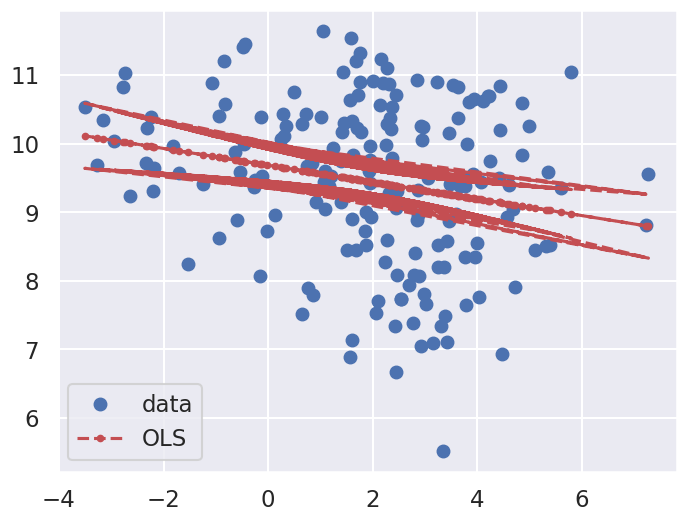

In [18]:
pred_ols = mod.get_prediction()
iv_l = pred_ols.summary_frame()["mean_ci_lower"]
iv_u = pred_ols.summary_frame()["mean_ci_upper"]

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(dffig.ln_pop, dffig.ln_gdp_pc_o, "o", label="data")
ax.plot(dffig.ln_pop, mod.fittedvalues, "r--.", label="OLS")
ax.plot(dffig.ln_pop, iv_u, "r--")
ax.plot(dffig.ln_pop, iv_l, "r--")
ax.legend(loc="best")

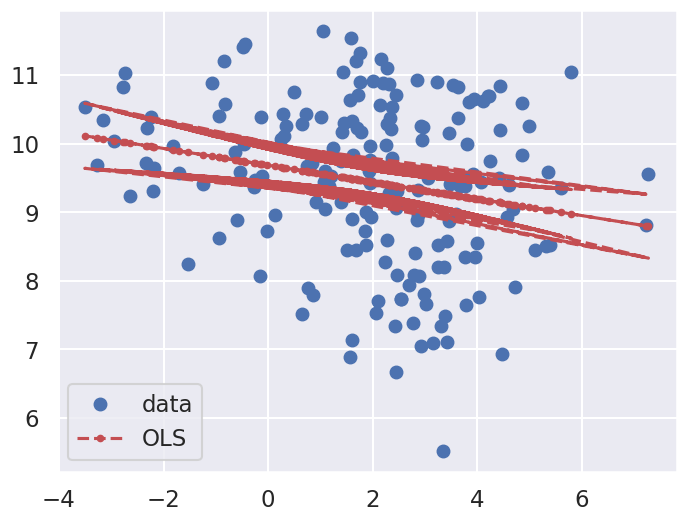

In [19]:
fig

## Simple Regression of Log[GDP pc] and Log[Population] accounting for WB region dummies

In [20]:
mod2 = smf.ols(formula='ln_gdp_pc_o ~ ln_pop + C(region)', data=dffig, missing='drop').fit()

In [21]:
mod2.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Ordinary least squares
=======================================================================================
Model:                      OLS                     Adj. R-squared:            0.521   
Dependent Variable:         ln_gdp_pc_o             AIC:                       445.3768
Date:                       2024-10-28 15:48        BIC:                       470.9205
No. Observations:           180                     Log-Likelihood:            -214.69 
Df Model:                   7                       F-statistic:               28.77   
Df Residuals:               172                     Prob (F-statistic):        5.29e-26
R-squared:                  0.539                   Scale:                     0.66565 
---------------------------------------------------------------------------------------
                                         Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
---------------------------------------------------------------------------------------
Intercept                               10.3696   0.2087 49.6849 0.0000  9.9577 10.7816
C(region)[T.Europe & Central Asia]       0.1774   0.2228  0.7965 0.4268 -0.2623  0.6171
C(region)[T.Latin America & Caribbean ] -0.8154   0.2415 -3.3764 0.0009 -1.2921 -0.3387
C(region)[T.Middle East & North Africa] -0.2627   0.2621 -1.0023 0.3176 -0.7800  0.2547
C(region)[T.North America]               0.8356   0.5074  1.6469 0.1014 -0.1659  1.8371
C(region)[T.South Asia]                 -0.9465   0.3609 -2.6224 0.0095 -1.6589 -0.2341
C(region)[T.Sub-Saharan Africa ]        -1.9006   0.2244 -8.4687 0.0000 -2.3436 -1.4576
ln_pop                                  -0.1397   0.0315 -4.4363 0.0000 -0.2019 -0.0776
---------------------------------------------------------------------------------------
Omnibus:                      17.710              Durbin-Watson:                 2.181 
Prob(Omnibus):                0.000               Jarque-Bera (JB):              25.430
Skew:                         -0.585              Prob(JB):                      0.000 
Kurtosis:                     4.421               Condition No.:                 28    
=======================================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly
specified.
"""

## Simple Regression of Log[GDP pc] (Expenditure based GDP) and Log[Population]

In [22]:
mod3 = smf.ols(formula='ln_gdp_pc_e ~ ln_pop', data=dffig, missing='drop').fit()

In [23]:
mod3.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.056   
Dependent Variable: ln_gdp_pc_e      AIC:                571.5983
Date:               2024-10-28 15:48 BIC:                577.9842
No. Observations:   180              Log-Likelihood:     -283.80 
Df Model:           1                F-statistic:        11.72   
Df Residuals:       178              Prob (F-statistic): 0.000768
R-squared:          0.062            Scale:              1.3863  
------------------------------------------------------------------
               Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
------------------------------------------------------------------
Intercept      9.7404    0.1199  81.2694  0.0000   9.5039   9.9769
ln_pop        -0.1437    0.0420  -3.4232  0.0008  -0.2266  -0.0609
-----------------------------------------------------------------
Omnibus:               6.582        Durbin-Watson:          1.102
Prob(Omnibus):         0.037        Jarque-Bera (JB):       6.621
Skew:                  -0.436       Prob(JB):               0.036
Kurtosis:              2.650        Condition No.:          4    
=================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the
errors is correctly specified.
"""

## Simple Regression of Log[GDP pc] (Expenditure based GDP) and Log[Population], accounting for WB region dummies

In [24]:
mod4 = smf.ols(formula='ln_gdp_pc_e ~ ln_pop + C(region)', data=dffig, missing='drop').fit()

In [25]:
mod4.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Ordinary least squares
=======================================================================================
Model:                      OLS                     Adj. R-squared:            0.529   
Dependent Variable:         ln_gdp_pc_e             AIC:                       452.5339
Date:                       2024-10-28 15:48        BIC:                       478.0776
No. Observations:           180                     Log-Likelihood:            -218.27 
Df Model:                   7                       F-statistic:               29.67   
Df Residuals:               172                     Prob (F-statistic):        1.30e-26
R-squared:                  0.547                   Scale:                     0.69265 
---------------------------------------------------------------------------------------
                                         Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
---------------------------------------------------------------------------------------
Intercept                               10.4302   0.2129 48.9914 0.0000 10.0100 10.8504
C(region)[T.Europe & Central Asia]       0.1805   0.2272  0.7945 0.4280 -0.2680  0.6291
C(region)[T.Latin America & Caribbean ] -0.7968   0.2464 -3.2345 0.0015 -1.2831 -0.3106
C(region)[T.Middle East & North Africa] -0.3045   0.2674 -1.1390 0.2563 -0.8323  0.2232
C(region)[T.North America]               0.9720   0.5176  1.8780 0.0621 -0.0496  1.9936
C(region)[T.South Asia]                 -0.9943   0.3682 -2.7005 0.0076 -1.7210 -0.2675
C(region)[T.Sub-Saharan Africa ]        -1.9388   0.2289 -8.4690 0.0000 -2.3907 -1.4869
ln_pop                                  -0.1585   0.0321 -4.9327 0.0000 -0.2219 -0.0951
---------------------------------------------------------------------------------------
Omnibus:                      18.774              Durbin-Watson:                 2.181 
Prob(Omnibus):                0.000               Jarque-Bera (JB):              25.503
Skew:                         -0.643              Prob(JB):                      0.000 
Kurtosis:                     4.323               Condition No.:                 28    
=======================================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly
specified.
"""

# Producing a nice table with **stargazer**

In [26]:
url = 'https://nbviewer.org/github/mwburke/stargazer/blob/master/examples.ipynb'
IFrame(url, width=800, height=400)

## Add the estimated models to **Stargazer**

In [27]:
stargazer = Stargazer([mod, mod2, mod3, mod4])

In [28]:
stargazer.significant_digits(2)
stargazer.show_degrees_of_freedom(False)
stargazer.dep_var_name = 'Dependent Variable:'
stargazer.dependent_variable = ' Log[GDP per capita (' + str(year) + ')]'
stargazer.custom_columns(['Output Based GDP', 'Expenditure Based GDP'], [2, 2])
#stargazer.show_model_numbers(False)
stargazer.rename_covariates({'ln_pop':'Log[Population]'}), 
stargazer.add_line('WB Region FE', ['No', 'Yes', 'No', 'Yes'], LineLocation.FOOTER_TOP)
stargazer.covariate_order(['ln_pop'])
stargazer.cov_spacing = 2

In [29]:
stargazer

## To show the table
```python
HTML(stargazer.render_html())
```

In [30]:
HTML(stargazer.render_html())

## To export the table to another file

In [31]:
file_name = "table-pwt.html" #Include directory path if needed
html_file = open(pathgraphs + file_name, "w" ) #This will overwrite an existing file
html_file.write( stargazer.render_html() )
html_file.close()

In [32]:
url = pathgraphs + 'table-pwt.html'
url = 'https://smu-econ-growth.github.io/EconGrowthUG-Slides-Working-with-PWT/table-pwt.html'
IFrame(url, width=500, height=300)

# Plotting PWT data

## Many options
* Since the data is a **pandas** dataframe, we could just use its functions as [we did previously](./Intro-Data-Analysis-Pandas.ipynb)
* Use the **[seaborn](https://seaborn.pydata.org/index.html)** package
* Use the **[plotly](https://plotly.com/python/)** package
* Use the **[plotnine](https://plotnine.readthedocs.io/en/stable/)** package

# Plots with 
<center><a href="https://seaborn.pydata.org/index.html#"><img src="https://raw.githubusercontent.com/SMU-Econ-Growth/EconGrowthUG-Notebooks/main/pics/logo-wide-lightbg.svg" alt="seaborn" width=700/></a></center>

In [33]:
url = 'https://seaborn.pydata.org/examples/index.html'
IFrame(url, width=800, height=400)

Let's create a [Scatterplot with varying point sizes and hues](https://seaborn.pydata.org/examples/scatter_bubbles.html) that plots the Log[Population] (expediture based) and Log[GDP per capita] of each country and uses its log-GDP per capita (output based) and the WB region in the last available year as the size and hue.

## Using [`relplot`](https://seaborn.pydata.org/generated/seaborn.relplot.html#seaborn.relplot)

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight


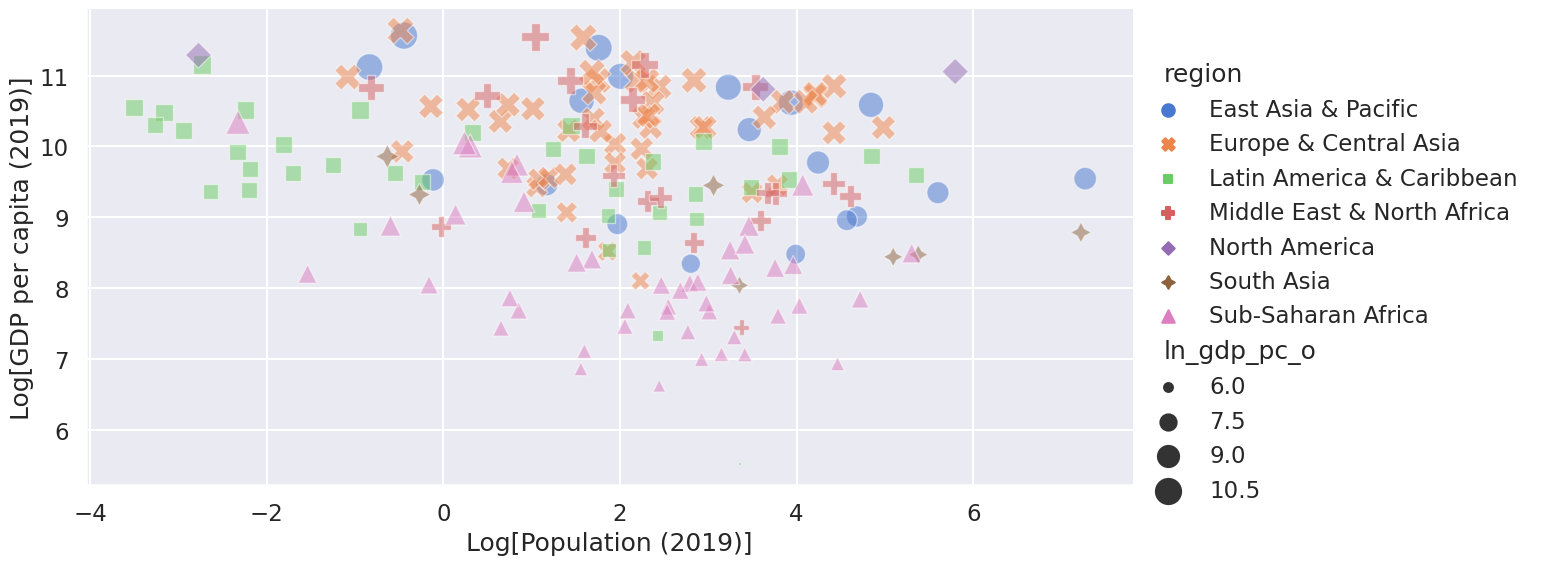

In [34]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_context("talk")

g = sns.relplot(x="ln_pop", 
            y="ln_gdp_pc_e", 
            data=dffig,
            hue="region",
            hue_order = dffig.region.drop_duplicates().sort_values(),
            style="region",
            style_order = dffig.region.drop_duplicates().sort_values(),
            size="ln_gdp_pc_o",
            sizes=(10, 400), 
            alpha=.5, 
            height=6,
            aspect=2,
            palette="muted",
           )
g.set_axis_labels('Log[Population (' + str(year) + ')]', 'Log[GDP per capita (' + str(year) + ')]')

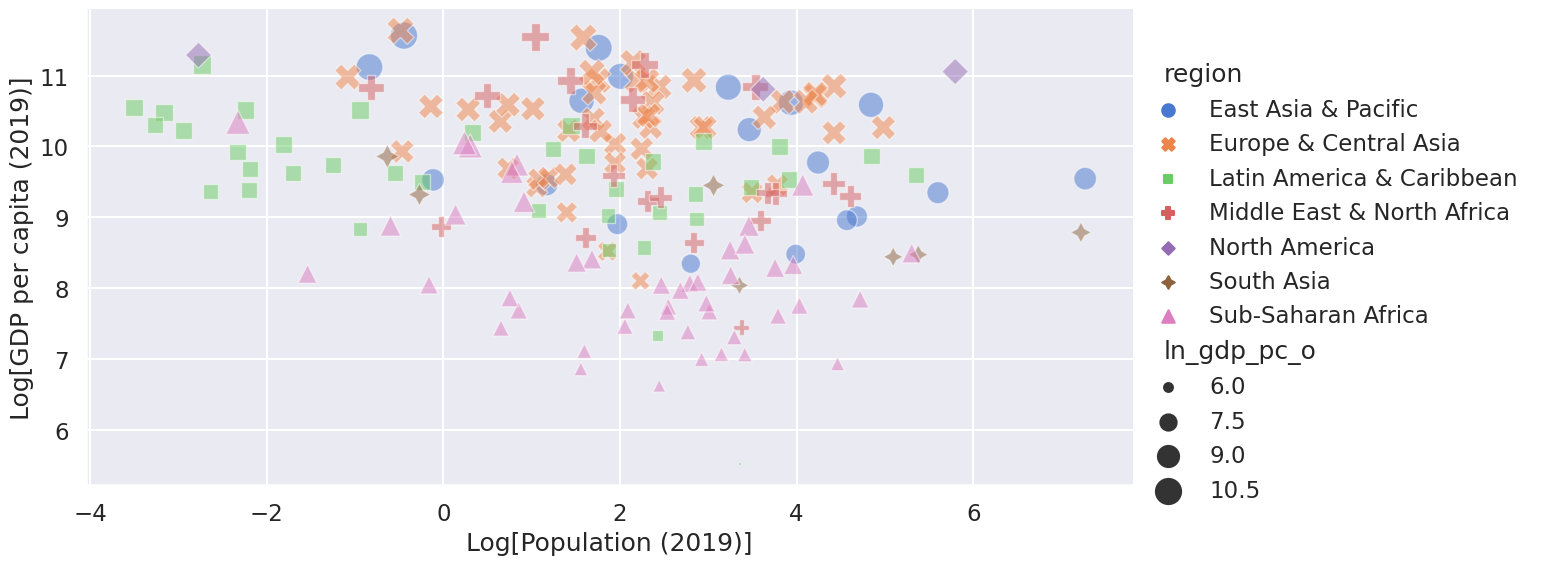

In [35]:
g.fig

# Using [`scatterplot`](https://seaborn.pydata.org/generated/seaborn.scatterplot.html)

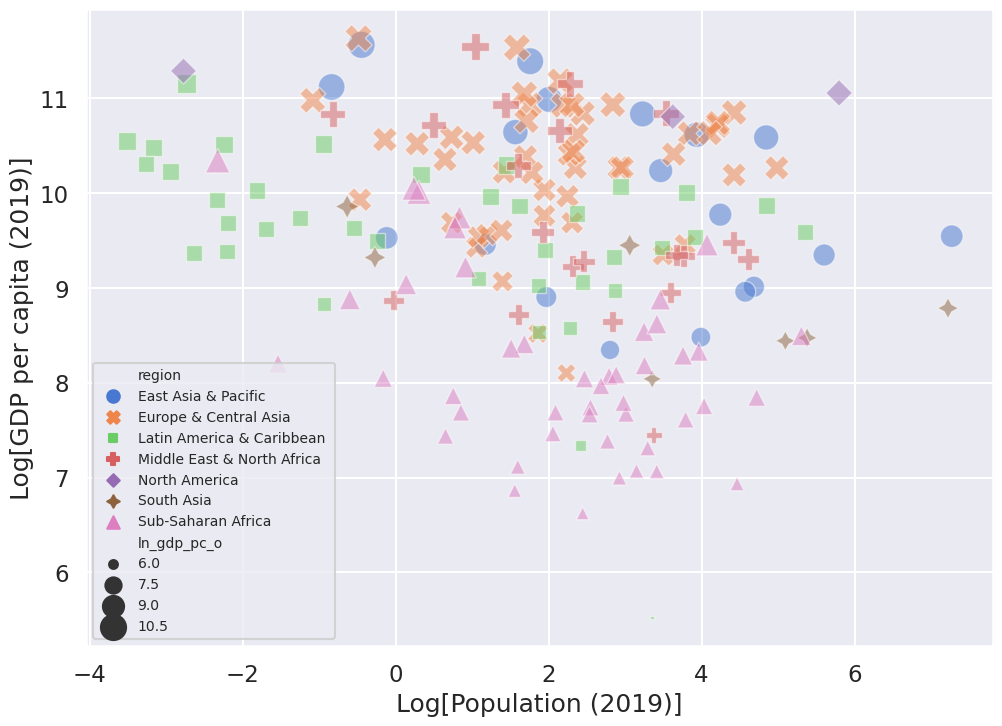

In [36]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_context("talk")

fig, ax = plt.subplots()
sns.scatterplot(x="ln_pop", 
                y="ln_gdp_pc_e", 
                data=dffig,
                hue="region",
                hue_order = dffig.region.drop_duplicates().sort_values(),
                style="region",
                style_order = dffig.region.drop_duplicates().sort_values(),
                size="ln_gdp_pc_o",
                sizes=(10, 400), 
                alpha=.5, 
                palette="muted",
                ax=ax
               )
ax.set_xlabel('Log[Population (' + str(year) + ')]')
ax.set_ylabel('Log[GDP per capita (' + str(year) + ')]')
ax.legend(fontsize=10)

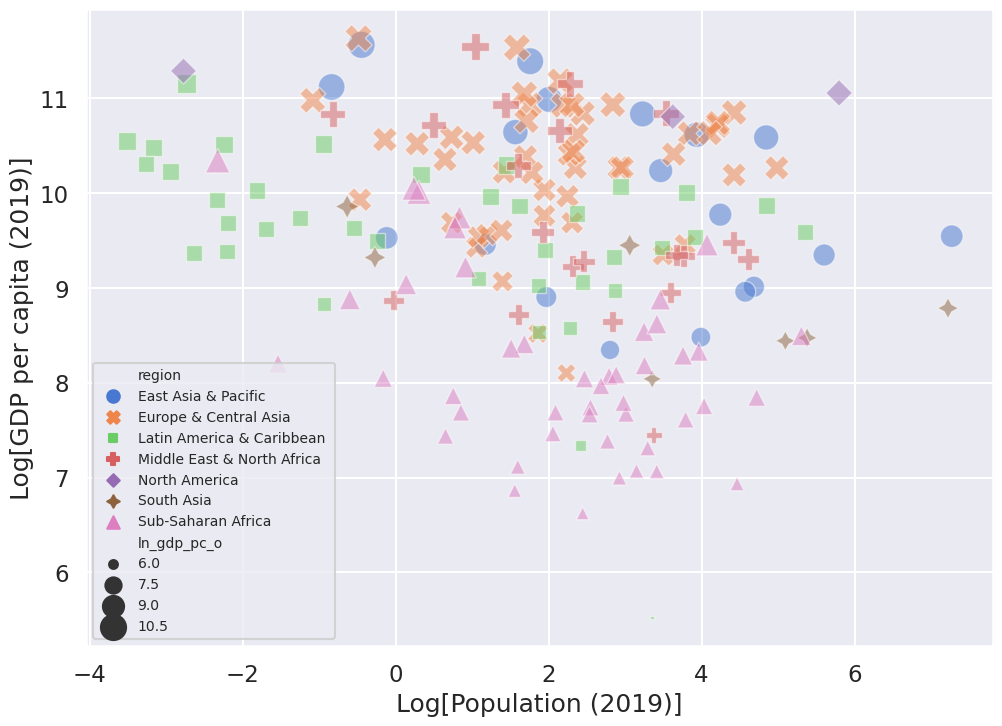

In [37]:
fig

# Based on **seaborn** we can create a useful functions that create plots for us
## E.g., scatter plots with labels, OLS regression lines, 45 degree lines, etc

In [38]:
def my_xy_plot(dfin, 
               x='ln_pop', 
               y='ln_gdp_pc_o', 
               labelvar='iso3c', 
               dx=0.006125, 
               dy=0.006125, 
               xlogscale=False, 
               ylogscale=False,
               xlabel='Log[Population ' +  str(year) + ']', 
               ylabel='Log[Income per capita in ' +  str(year) + ']',
               labels=False,
               xpct = False,
               ypct = False,
               OLS=False,
               OLSlinelabel='OLS',
               ssline=False,
               sslinelabel='45 Degree Line',
               filename='income-pop-growth.pdf',
               hue='region',
               hue_order=['East Asia & Pacific', 'Europe & Central Asia',
                          'Latin America & Caribbean ', 'Middle East & North Africa',
                          'North America', 'South Asia', 'Sub-Saharan Africa '],
               style='incomeLevel', 
               style_order=['High Income', 'Upper Middle Income', 'Lower Middle Income', 'Low Income'],
               palette=None,
               size=None,
               sizes=None,
               fontsize=10,
               label_font_size=12,
               save=True):
    '''
    Plot the association between x and var in dataframe using labelvar for labels.
    '''
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.set_context("talk")
    df = dfin.copy()
    df = df.dropna(subset=[x, y]).reset_index(drop=True)
    # Plot
    k = 0
    fig, ax = plt.subplots()
    sns.scatterplot(x=x, y=y, data=df, ax=ax, 
                    hue=hue,
                    hue_order=hue_order,
                    #hue='incomeLevel',
                    #hue_order=['High Income', 'Upper Middle Income', 'Lower Middle Income', 'Low Income'],
                    #hue_order=['East Asia & Pacific', 'Europe & Central Asia',
                    #           'Latin America & Caribbean ', 'Middle East & North Africa',
                    #           'North America', 'South Asia', 'Sub-Saharan Africa '],
                    alpha=1, 
                    style=style, 
                    style_order=style_order,
                    palette=palette,
                    size=size,
                    sizes=sizes,
                    #palette=sns.color_palette("Blues_r", df[hue].unique().shape[0]+6)[:df[hue].unique().shape[0]*2:2],
                )
    if OLS:
        sns.regplot(x=x, y=y, data=df, ax=ax, label=OLSlinelabel, scatter=False)
    if ssline:
        ax.plot([df[x].min()*.99, df[x].max()*1.01], [df[x].min()*.99, df[x].max()*1.01], c='r', label=sslinelabel)
    if labels:
        movex = df[x].mean() * dx
        movey = df[y].mean() * dy
        for line in range(0,df.shape[0]):
            ax.text(df[x][line]+movex, df[y][line]+movey, df[labelvar][line], horizontalalignment='left', fontsize=label_font_size, color='black')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if xpct:
        fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
        xticks = mtick.FormatStrFormatter(fmt)
        ax.xaxis.set_major_formatter(xticks)
    if ypct:
        fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
        yticks = mtick.FormatStrFormatter(fmt)
        ax.yaxis.set_major_formatter(yticks)
    if ylogscale:
        ax.set(yscale="log")
    if xlogscale:
        ax.set(xscale="log")
    handles, labels = ax.get_legend_handles_labels()
    handles = np.array(handles)
    labels = np.array(labels)
    handles = list(handles[(labels!=hue) & (labels!=style) & (labels!=size)])
    labels = list(labels[(labels!=hue) & (labels!=style) & (labels!=size)])
    ax.legend(handles=handles, labels=labels, fontsize=fontsize)
    if save:
        plt.savefig(pathgraphs + filename, dpi=300, bbox_inches='tight')
    return fig

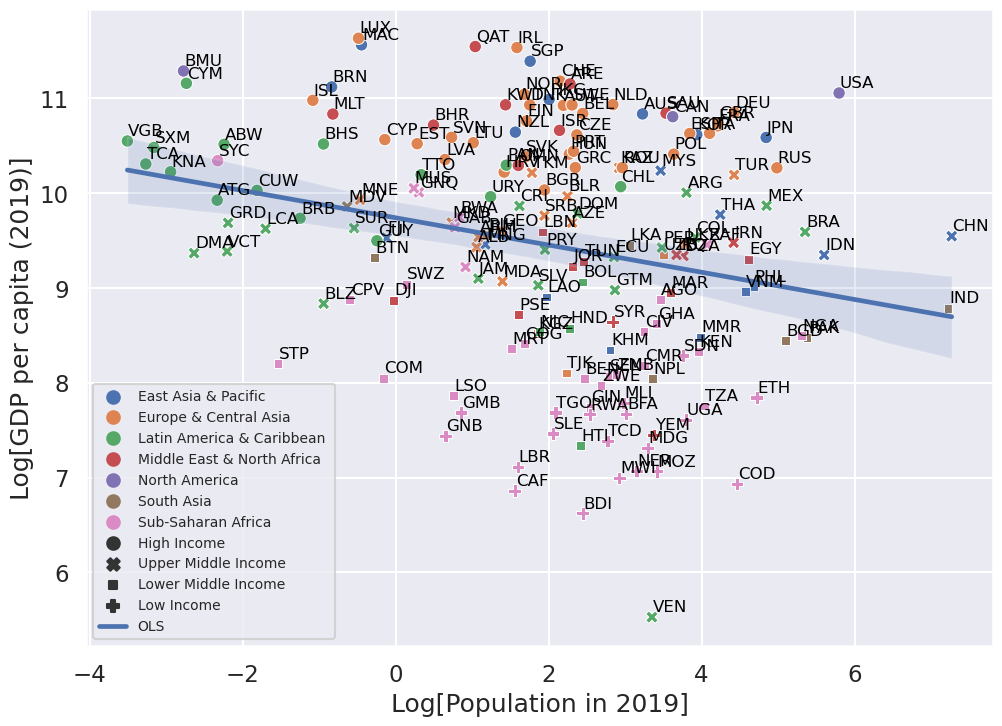

In [39]:
g = my_xy_plot(dffig, 
           x='ln_pop', 
           y='ln_gdp_pc_e', 
           xlabel='Log[Population in ' +  str(year) + ']', 
           ylabel='Log[GDP per capita (' + str(year) +')]', 
           OLS=True, 
           labels=True, 
           filename='ln-gdp-pc-pop-pwt.pdf')

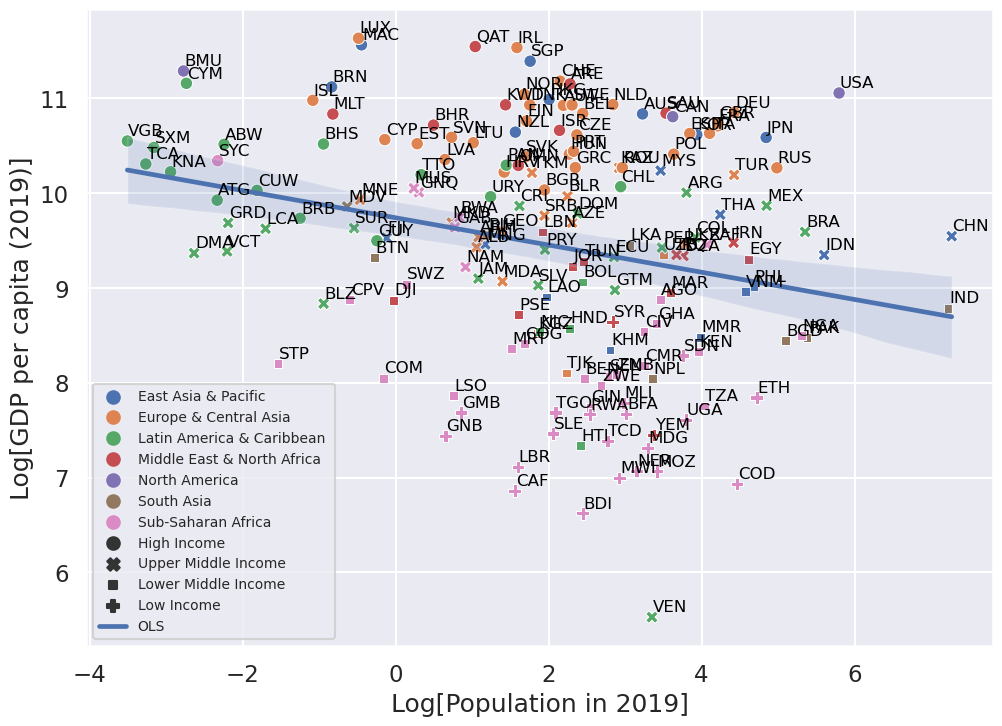

In [40]:
g

## Compare Both GDP per capita measures

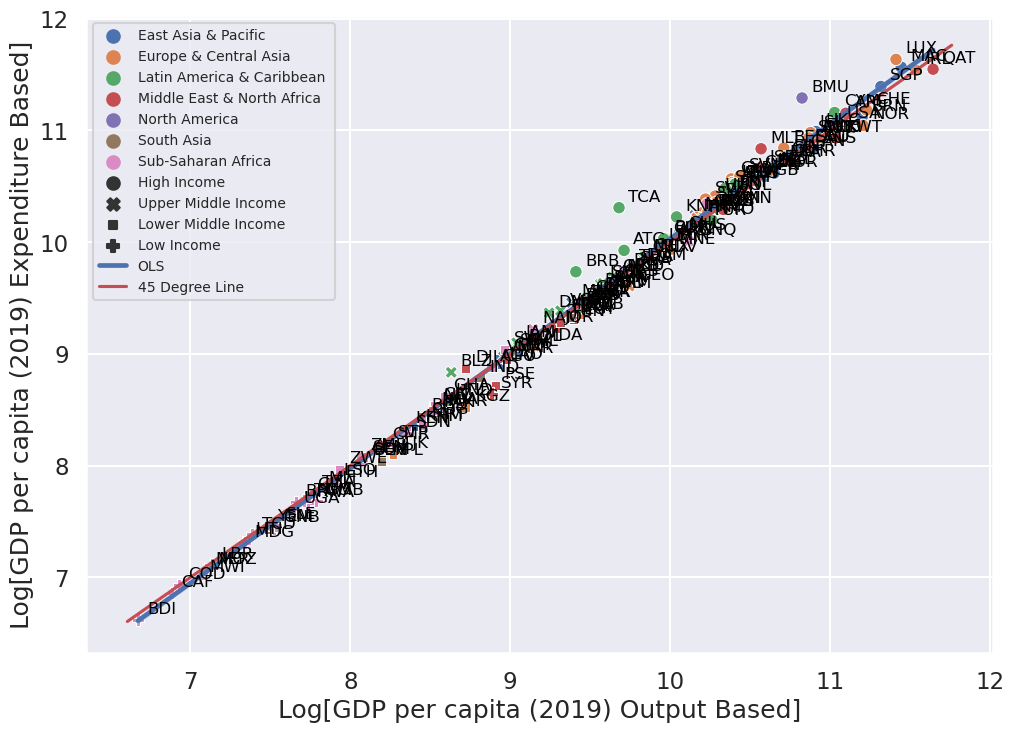

In [41]:
g = my_xy_plot(dffig.loc[dffig.iso3c!='VEN'], 
               x='ln_gdp_pc_o', 
               y='ln_gdp_pc_e', 
               xlabel='Log[GDP per capita (' + str(year) +') Output Based]', 
               ylabel='Log[GDP per capita (' + str(year) +') Expenditure Based]', 
               OLS=True,
               ssline=True,
               labels=True, 
               label_font_size=12,
               filename='ln-gdp-pc-out-exp.pdf')

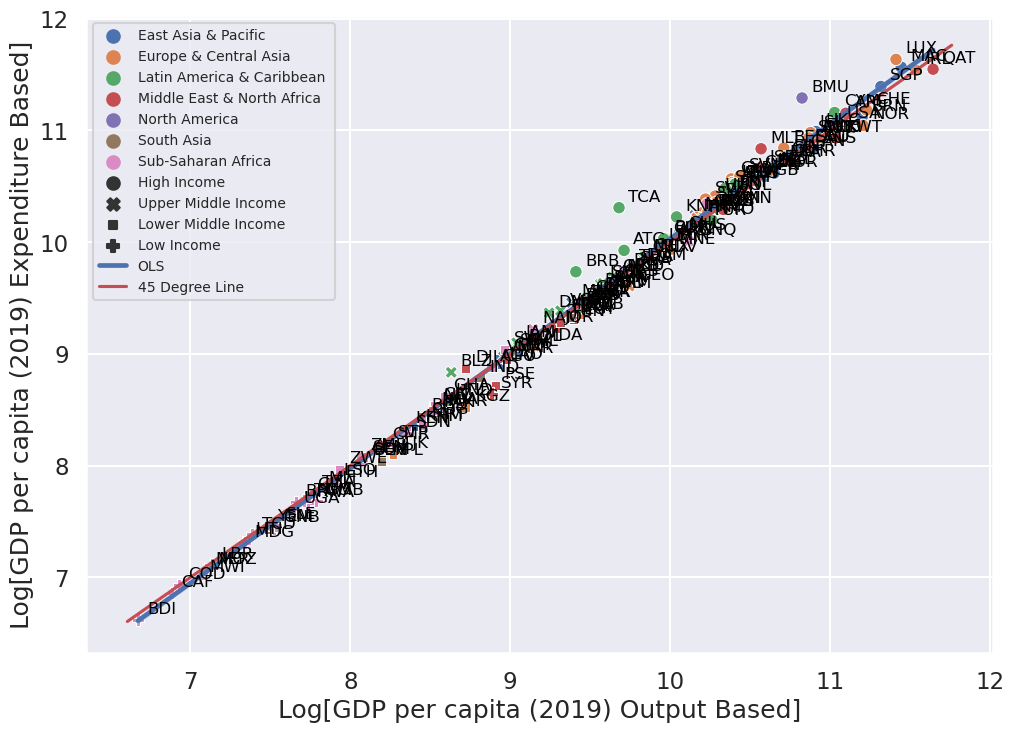

In [42]:
g

## Plot the evolution of variables across time by groups

In [43]:
def my_xy_line_plot(dfin, 
                    x='year', 
                    y='ln_gdp_pc_e', 
                    labelvar='iso3c', 
                    dx=0.006125, 
                    dy=0.006125, 
                    xlogscale=False, 
                    ylogscale=False,
                    xlabel='Growth Rate of Population', 
                    ylabel='Log[Income per capita in ' +  str(year) + ']',
                    labels=False,
                    xpct = False,
                    ypct = False,
                    OLS=False,
                    OLSlinelabel='OLS',
                    ssline=False,
                    sslinelabel='45 Degree Line',
                    filename='income-pop-growth.pdf',
                    hue='region',
                    hue_order=['East Asia & Pacific', 'Europe & Central Asia',
                               'Latin America & Caribbean ', 'Middle East & North Africa',
                               'North America', 'South Asia', 'Sub-Saharan Africa '],
                    style='incomeLevel', 
                    style_order=['High Income', 'Upper Middle Income', 'Lower Middle Income', 'Low Income'],
                    palette=None,
                    legend_fontsize=10,
                    label_font_size=12,
                    loc=None,
                    save=True):
    '''
    Plot the association between x and var in dataframe using labelvar for labels. 
    '''
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.set_context("talk")
    df = dfin.copy()
    df = df.dropna(subset=[x, y]).reset_index(drop=True)
    # Plot
    k = 0
    fig, ax = plt.subplots()
    sns.lineplot(x=x, y=y, data=df, ax=ax, 
                    hue=hue,
                    hue_order=hue_order,
                    alpha=1, 
                    style=style, 
                    style_order=style_order,
                    palette=palette,
                )
    if OLS:
        sns.regplot(x=x, y=y, data=df, ax=ax, label=OLSlinelabel, scatter=False)
    if ssline:
        ax.plot([df[x].min()*.99, df[x].max()*1.01], [df[x].min()*.99, df[x].max()*1.01], c='r', label=sslinelabel)
    if labels:
        movex = df[x].mean() * dx
        movey = df[y].mean() * dy
        for line in range(0,df.shape[0]):
            ax.text(df[x][line]+movex, df[y][line]+movey, df[labelvar][line], horizontalalignment='left', fontsize=label_fontsize, color='black')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if xpct:
        fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
        xticks = mtick.FormatStrFormatter(fmt)
        ax.xaxis.set_major_formatter(xticks)
    if ypct:
        fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
        yticks = mtick.FormatStrFormatter(fmt)
        ax.yaxis.set_major_formatter(yticks)
    if ylogscale:
        ax.set(yscale="log")
    if xlogscale:
        ax.set(xscale="log")
    handles, labels = ax.get_legend_handles_labels()
    handles = np.array(handles)
    labels = np.array(labels)
    handles = list(handles[(labels!='region') & (labels!='incomeLevel')])
    labels = list(labels[(labels!='region') & (labels!='incomeLevel')])
    ax.legend(handles=handles, labels=labels, fontsize=legend_fontsize, loc=loc)
    if save:
        plt.savefig(pathgraphs + filename, dpi=300, bbox_inches='tight')
    return fig

## Log[GDP per capita across the world] by WB Income Groups

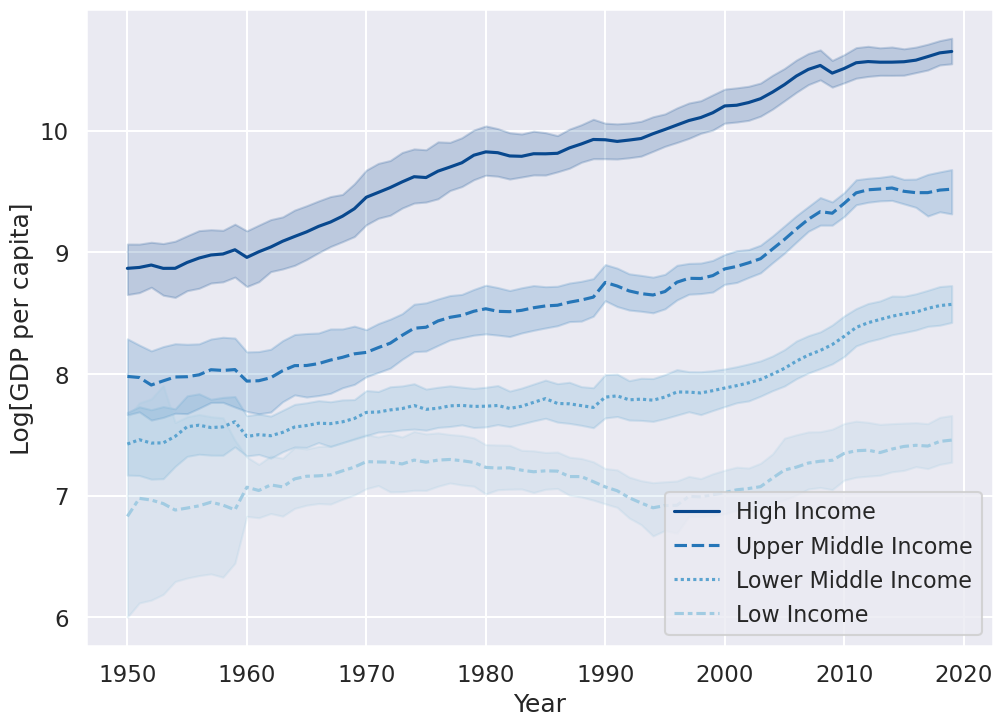

In [44]:
palette=sns.color_palette("Blues_r", df['incomeLevel'].unique().shape[0]+6)[:df['incomeLevel'].unique().shape[0]*2:2]
fig = my_xy_line_plot(df, 
                x='year', 
                y='ln_gdp_pc_e', 
                xlabel='Year',
                ylabel='Log[GDP per capita]',
                filename='ln-gdp-pc-income-groups-TS-pwt.pdf',
                hue='incomeLevel',
                hue_order=['High Income', 'Upper Middle Income', 'Lower Middle Income', 'Low Income'],
                palette=palette,
                OLS=False, 
                labels=False,
                legend_fontsize=16,
                loc='lower right',
                save=True)

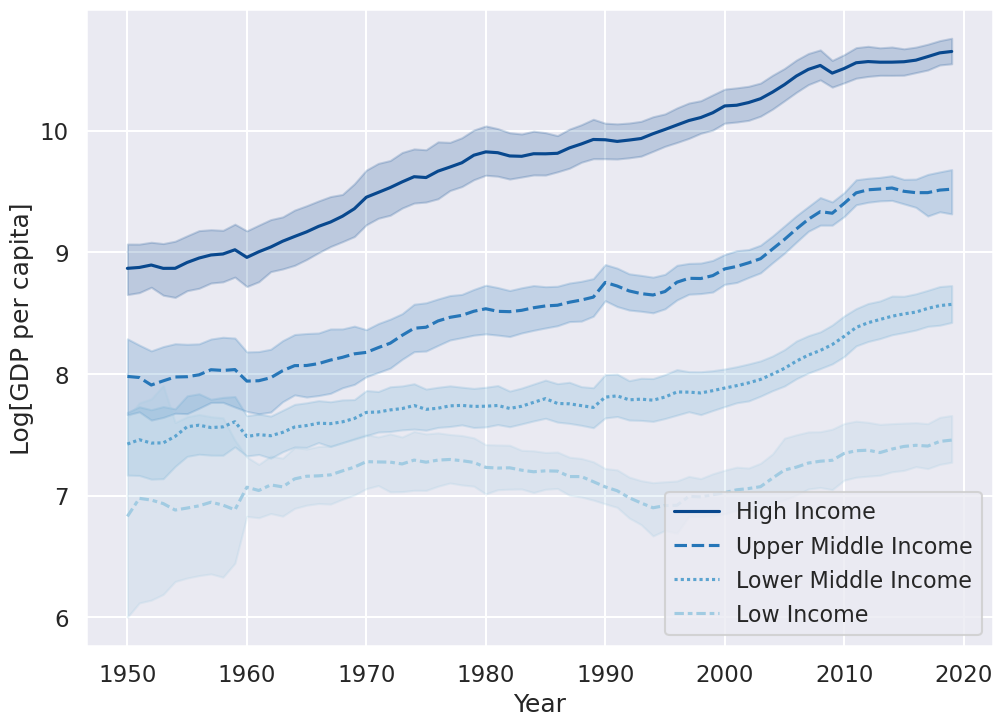

In [45]:
fig

## GDP per capita across the world by WB Regions

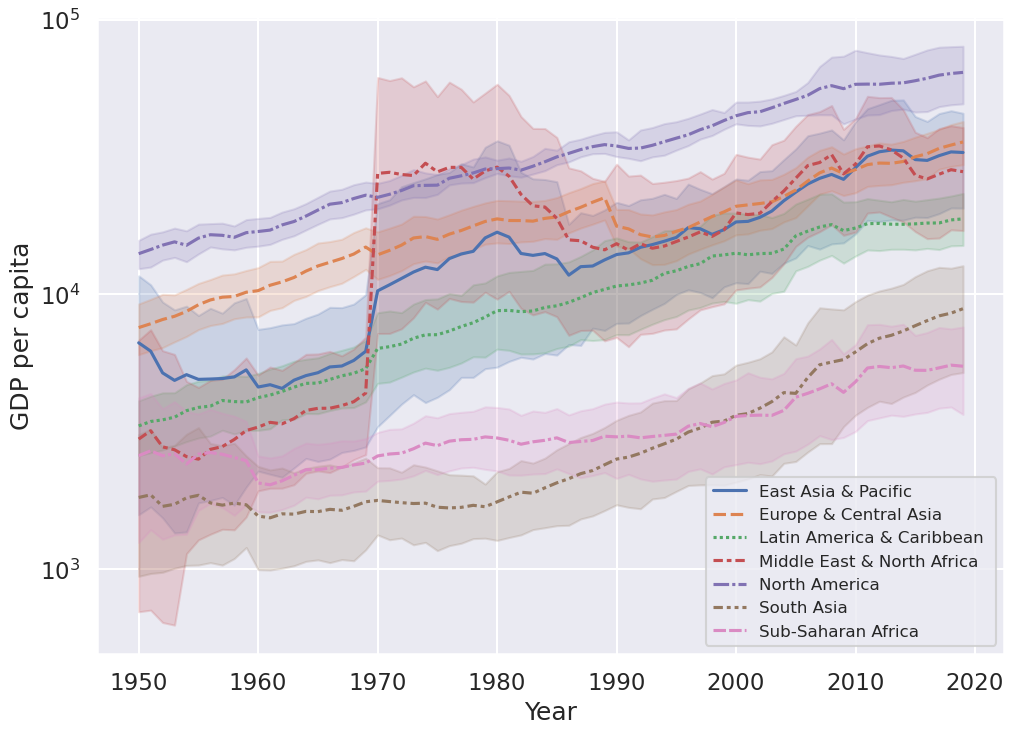

In [46]:
#palette=sns.color_palette("Blues_r", wdi['region'].unique().shape[0]+6)[:wdi['region'].unique().shape[0]*2:2]
fig = my_xy_line_plot(df, 
                      x='year', 
                      y='gdp_pc_e', 
                      xlabel='Year',
                      ylabel='GDP per capita',
                      ylogscale=True,
                      filename='ln-gdp-pc-regions-TS-pwt.pdf',
                      style='region',
                      style_order=['East Asia & Pacific', 'Europe & Central Asia',
                                   'Latin America & Caribbean ', 'Middle East & North Africa',
                                   'North America', 'South Asia', 'Sub-Saharan Africa '],
                      #palette=palette,
                      OLS=False, 
                      labels=False,
                      legend_fontsize=12,
                      loc='lower right',
                      save=True)

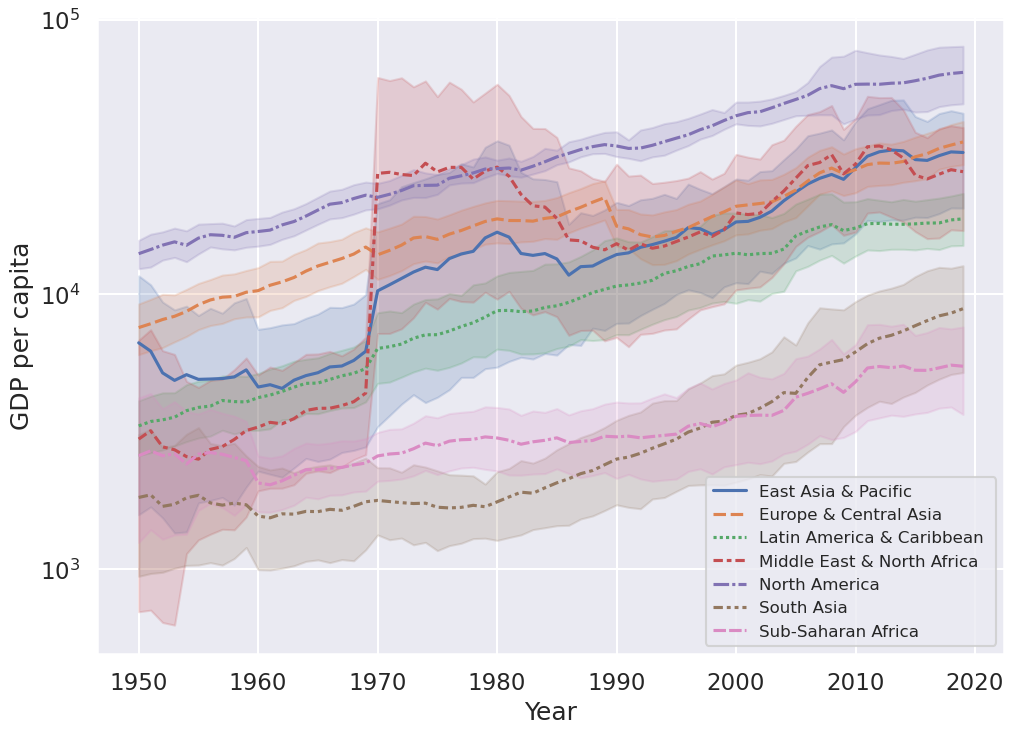

In [47]:
fig

# Plots with 
<center><a href="https://plotly.com/python/"><img src="https://raw.githubusercontent.com/SMU-Econ-Growth/EconGrowthUG-Notebooks/main/pics/plot_ly-ar21.svg" alt="plotly express" width=500/></a></center>

In [48]:
url = 'https://plotly.com/python/'
IFrame(url, width=800, height=400)

## Let's [select symbols to plot](https://plotly.com/python/marker-style/) so it looks like the previous ones and also to improve visibility

In [49]:
symbols = ['circle', 'x', 'square', 'cross', 'diamond', 'star-diamond', 'triangle-up']
fig = px.scatter(dffig,
                 x="ln_pop", 
                 y="ln_gdp_pc_e", 
                 color='region',
                 symbol='region',
                 symbol_sequence=symbols,
                 hover_name='name',
                 hover_data=['iso3c', 'ln_pop', 'gdp_pc_o', 'gdp_pc_e'],
                 size='ln_gdp_pc_o',
                 size_max=15,
                 trendline="ols",
                 trendline_scope="overall",
                 trendline_color_override="black",
                 labels={
                     "ln_pop": "Log[Population (" + str(year) + ")]",
                     "ln_gdp_pc_o": "Log[GDP per capita (" + str(year) + ")] (Output Based)",
                     "ln_gdp_pc_e": "Log[GDP per capita (" + str(year) + ")] (Expenditure Based)",
                     "gdp_pc_o": "GDP per capita (" + str(year) + ") (Output Based)",
                     "gdp_pc_e": "GDP per capita (" + str(year) + ") (Expenditure Based)",
                     "region": "WB Region"
                 },
                 opacity=0.75,
                 height=800,
                )

In [50]:
fig.show()

# Change marker borders

In [51]:
fig.update_traces(marker=dict(#size=12,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

In [52]:
fig.show()

# Increase width of trend line

In [53]:
tr_line=[]
for  k, trace  in enumerate(fig.data):
        if trace.mode is not None and trace.mode == 'lines':
            tr_line.append(k)
print(tr_line)
for id in tr_line:
    fig.data[id].update(line_width=3)

[7]


In [54]:
fig.show()

# Change legend position

In [55]:
fig.update_layout(legend=dict(
    yanchor="bottom",
    y=0.01,
    xanchor="left",
    x=0.01
))

In [56]:
fig.show()

# To save the figure use in your desired format
```python
fig.write_image(pathgraphs + "fig1.pdf")
fig.write_image(pathgraphs + "fig1.png")
fig.write_image(pathgraphs + "fig1.jpg")
```

In [57]:
fig.write_image(pathgraphs + "ln-gdp-pc-pop-plotly-pwt.pdf", height=1000, width=1500, scale=4)

## We can access the results of the regression in **plotly express**

In [58]:
results = px.get_trendline_results(fig)
results.px_fit_results.iloc[0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     11.72
Date:                Mon, 28 Oct 2024   Prob (F-statistic):           0.000768
Time:                        15:48:39   Log-Likelihood:                -283.80
No. Observations:                 180   AIC:                             571.6
Df Residuals:                     178   BIC:                             578.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.7404      0.120     81.269      0.000       9.504       9.977
x1            -0.1437      0.042     -3.423      0.001      -0.227      -0.061
==============================================================================
Omnibus:                        6.582   Durbin-Watson:                   1.705
Prob(Omnibus):                  0.037   Jarque-Bera (JB):                6.621
Skew:                          -0.436   Prob(JB):                       0.0365
Kurtosis:                       2.650   Cond. No.                         4.14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Maps with
<center><a href="https://seaborn.pydata.org/index.html#"><img src="https://raw.githubusercontent.com/SMU-Econ-Growth/EconGrowthUG-Notebooks/main/pics/logo-wide-lightbg.svg" alt="seaborn" width=700/></a></center>

# To create maps we need to obtain *geographical information*

There are various types of data in **Geographic Information Systems (GIS)**

* Location of cities, resources, etc. (point data)

* Shape of rivers, borders, countries, etc. (shape data)

* Numerical data for locations (elevation, temperature, number of people)

## Download Country boundary data from [Natural Earth](http://www.naturalearthdata.com/)

In [59]:
headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.103 Safari/537.36', 'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8'}

url = 'https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_countries.zip'
r = requests.get(url, headers=headers)
countries = gp.read_file(io.BytesIO(r.content))

## The boundary file is a **geopandas** dataframe

Text(0.5, 1.0, 'WGS84 (lat/lon)')

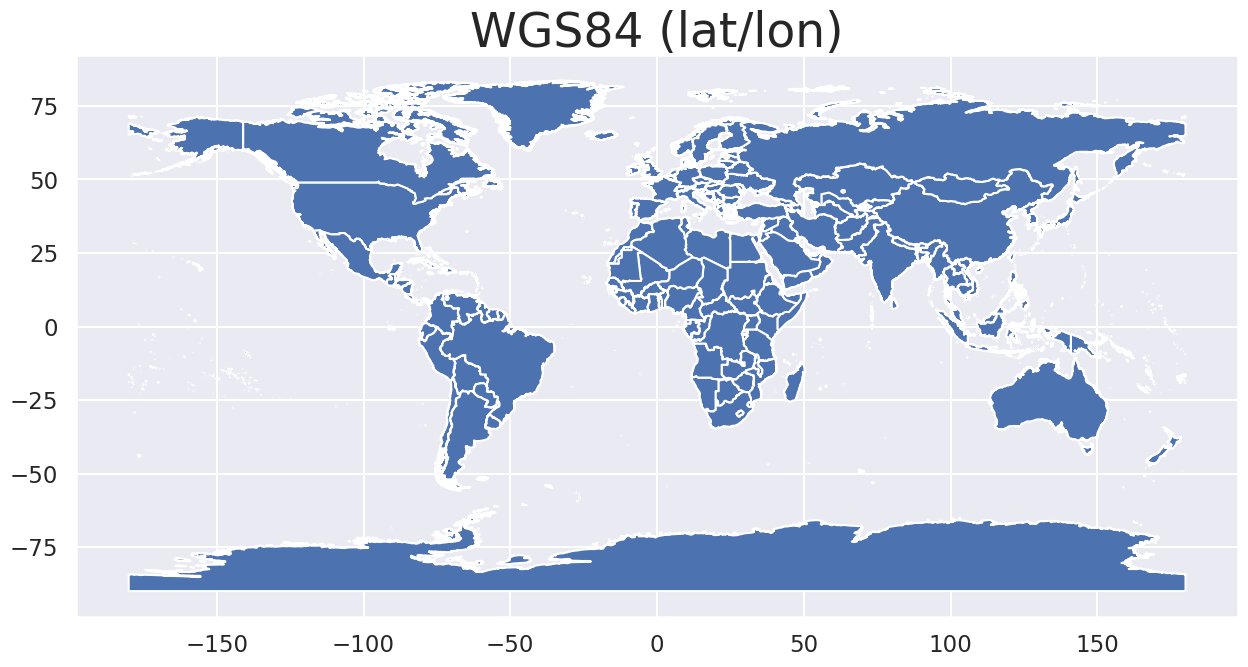

In [60]:
fig, ax = plt.subplots(figsize=(15,10))
countries.plot(ax=ax)
ax.set_title("WGS84 (lat/lon)", fontdict={'fontsize':34})

## Merge with other data and plot

In [61]:
dffig2 = countries.merge(dffig, left_on='ADM0_A3', right_on='iso3c')

Text(0.5, 1.0, 'WGS84 (lat/lon)')

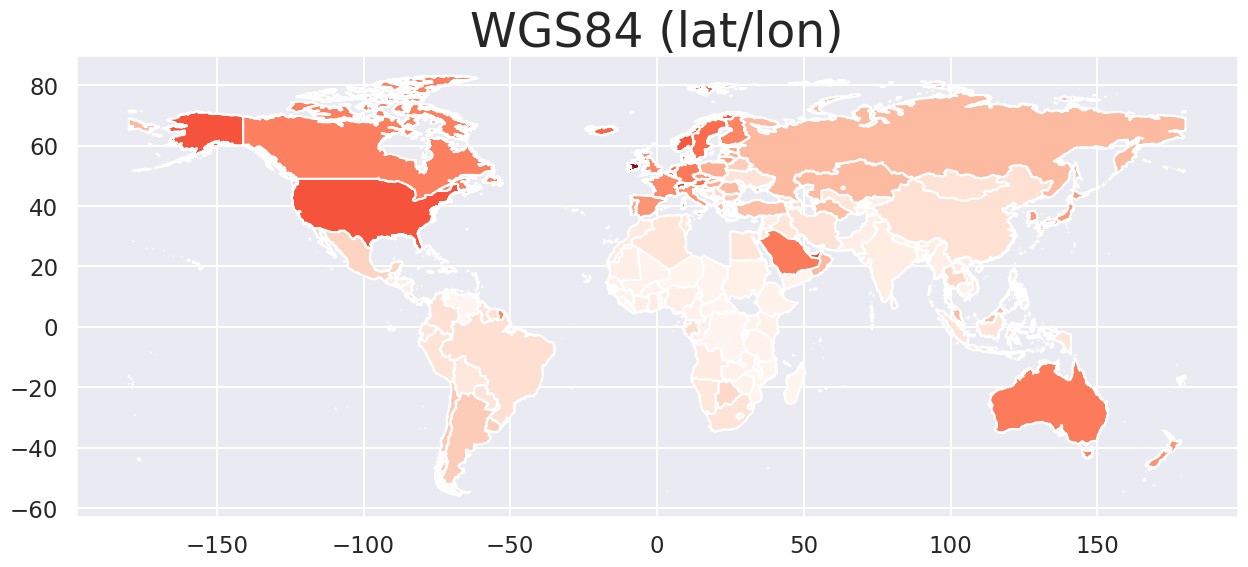

In [62]:
fig, ax = plt.subplots(figsize=(15,10))
dffig2.plot(column='gdp_pc_e', ax=ax, cmap='Reds')
ax.set_title("WGS84 (lat/lon)", fontdict={'fontsize':34})

# Maps with [geoplot](https://residentmario.github.io/geoplot/)

In [63]:
url = 'https://residentmario.github.io/geoplot/'
IFrame(url, width=800, height=400)

# Plot Countries

<GeoAxes: >

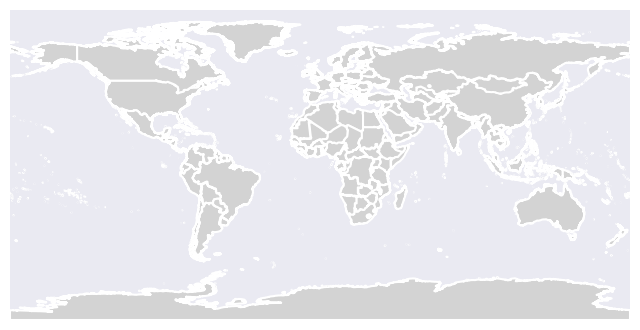

In [64]:
gplt.polyplot(
    countries, projection=gcrs.PlateCarree(central_longitude=0.0, globe=None),
    edgecolor='white', facecolor='lightgray',
    rasterized=True,
    extent=[-180, -90, 180, 90],
)

# Plot Data

<GeoAxes: >

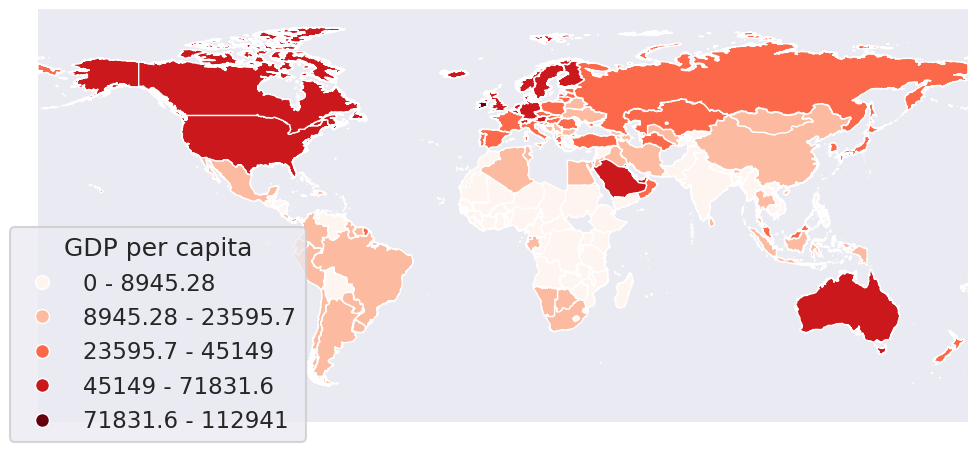

In [65]:
gplt.choropleth(dffig2, hue='gdp_pc_e', 
                projection=gcrs.PlateCarree(central_longitude=0.0, globe=None),
                edgecolor='white', 
                linewidth=1,
                cmap='Reds', 
                legend=True,
                scheme='FisherJenks',
                legend_kwargs={'bbox_to_anchor':(0.3, 0.5),
                               'frameon': True,
                               'title':'GDP per capita',
                              },
                figsize=(12,8),
                rasterized=True,
               )

# Data and Borders

<GeoAxes: >

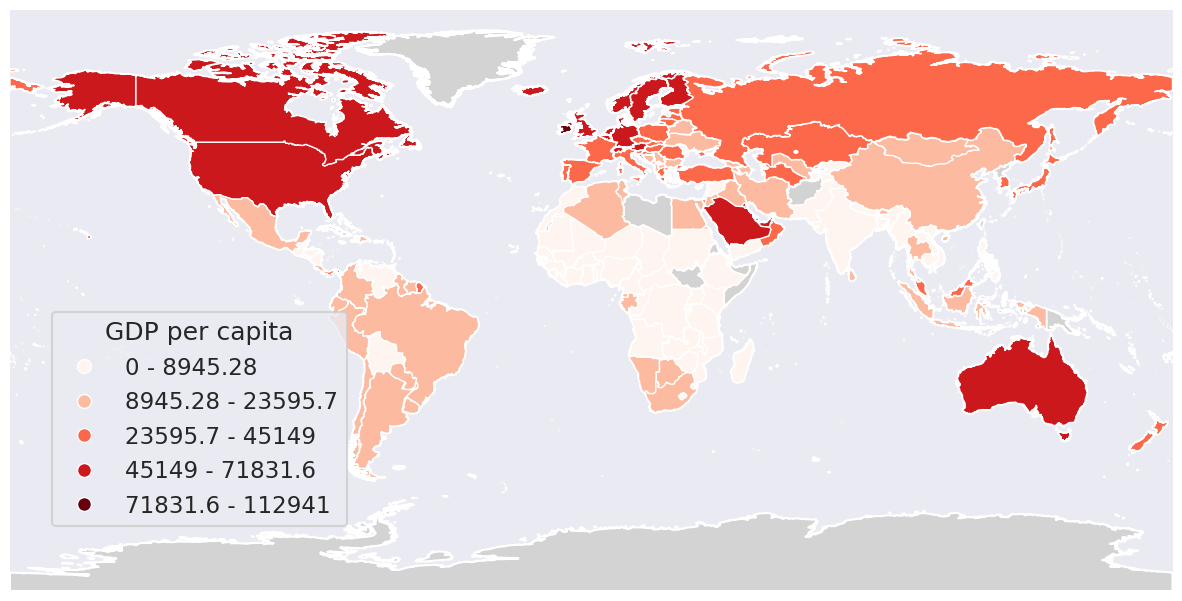

In [66]:
ax = gplt.choropleth(dffig2, hue='gdp_pc_e', projection=gcrs.PlateCarree(central_longitude=0.0, globe=None),
                     edgecolor='white', linewidth=1,
                     cmap='Reds', legend=True,
                     scheme='FisherJenks',
                     legend_kwargs={'bbox_to_anchor':(0.3, 0.5),
                                    'frameon': True,
                                    'title':'GDP per capita',
                                   },
                     figsize=(15,10),
                     rasterized=True,
                    )
gplt.polyplot(countries, projection=gcrs.PlateCarree(central_longitude=0.0, globe=None),
              edgecolor='white', facecolor='lightgray',
              ax=ax,
              rasterized=True,
              extent=[-180, -90, 180, 90],
             )

# Use a nice function

In [67]:
# Functions for plotting
def center_wrap(text, cwidth=32, **kw):
    '''Center Text (to be used in legend)'''
    lines = text
    #lines = textwrap.wrap(text, **kw)
    return "\n".join(line.center(cwidth) for line in lines)

def MyChloropleth(mydf, myfile='fig', myvar='gdp_pc_e',
                  mylegend='GDP per capita',
                  k=5,
                  extent=[-180, -90, 180, 90],
                  bbox_to_anchor=(0.25, 0.5),
                  edgecolor='white', facecolor='lightgray',
                  scheme='FisherJenks',
                  save=True,
                  percent=False,
                  rn=0,
                  **kwargs):
    # Chloropleth
    # Color scheme
    if scheme=='EqualInterval':
        scheme = mc.EqualInterval(mydf[myvar], k=k)
    elif scheme=='Quantiles':
        scheme = mc.Quantiles(mydf[myvar], k=k)
    elif scheme=='BoxPlot':
        scheme = mc.BoxPlot(mydf[myvar], k=k)
    elif scheme=='FisherJenks':
        scheme = mc.FisherJenks(mydf[myvar], k=k)
    elif scheme=='FisherJenksSampled':
        scheme = mc.FisherJenksSampled(mydf[myvar], k=k)
    elif scheme=='HeadTailBreaks':
        scheme = mc.HeadTailBreaks(mydf[myvar], k=k)
    elif scheme=='JenksCaspall':
        scheme = mc.JenksCaspall(mydf[myvar], k=k)
    elif scheme=='JenksCaspallForced':
        scheme = mc.JenksCaspallForced(mydf[myvar], k=k)
    elif scheme=='JenksCaspallSampled':
        scheme = mc.JenksCaspallSampled(mydf[myvar], k=k)
    elif scheme=='KClassifiers':
        scheme = mc.KClassifiers(mydf[myvar], k=k)
    # Format legend
    upper_bounds = scheme.bins
    # get and format all bounds
    bounds = []
    for index, upper_bound in enumerate(upper_bounds):
        if index == 0:
            lower_bound = mydf[myvar].min()
        else:
            lower_bound = upper_bounds[index-1]
        # format the numerical legend here
        if percent:
            bound = f'{lower_bound:.{rn}%} - {upper_bound:.{rn}%}'.format(width=rn)
        else:
            bound = f'{float(lower_bound):,.{rn}f} - {float(upper_bound):,.{rn}f}'.format(width=rn)
        bounds.append(bound)
    legend_labels = bounds
    #Plot
    ax = gplt.choropleth(
        mydf, hue=myvar, projection=gcrs.PlateCarree(central_longitude=0.0, globe=None),
        edgecolor='white', linewidth=1,
        cmap='Reds', legend=True,
        scheme=scheme,
        legend_kwargs={'bbox_to_anchor': bbox_to_anchor,
                       'frameon': True,
                       'title':mylegend,
                       },
        legend_labels = legend_labels,
        figsize=(24, 16),
        rasterized=True,
    )
    gplt.polyplot(
        countries, projection=gcrs.PlateCarree(central_longitude=0.0, globe=None),
        edgecolor=edgecolor, facecolor=facecolor,
        ax=ax,
        rasterized=True,
        extent=extent,
    )
    if save:
        plt.savefig(pathgraphs + myfile + '.pdf', dpi=300, bbox_inches='tight')
        plt.savefig(pathgraphs + myfile + '.png', dpi=300, bbox_inches='tight')
    pass

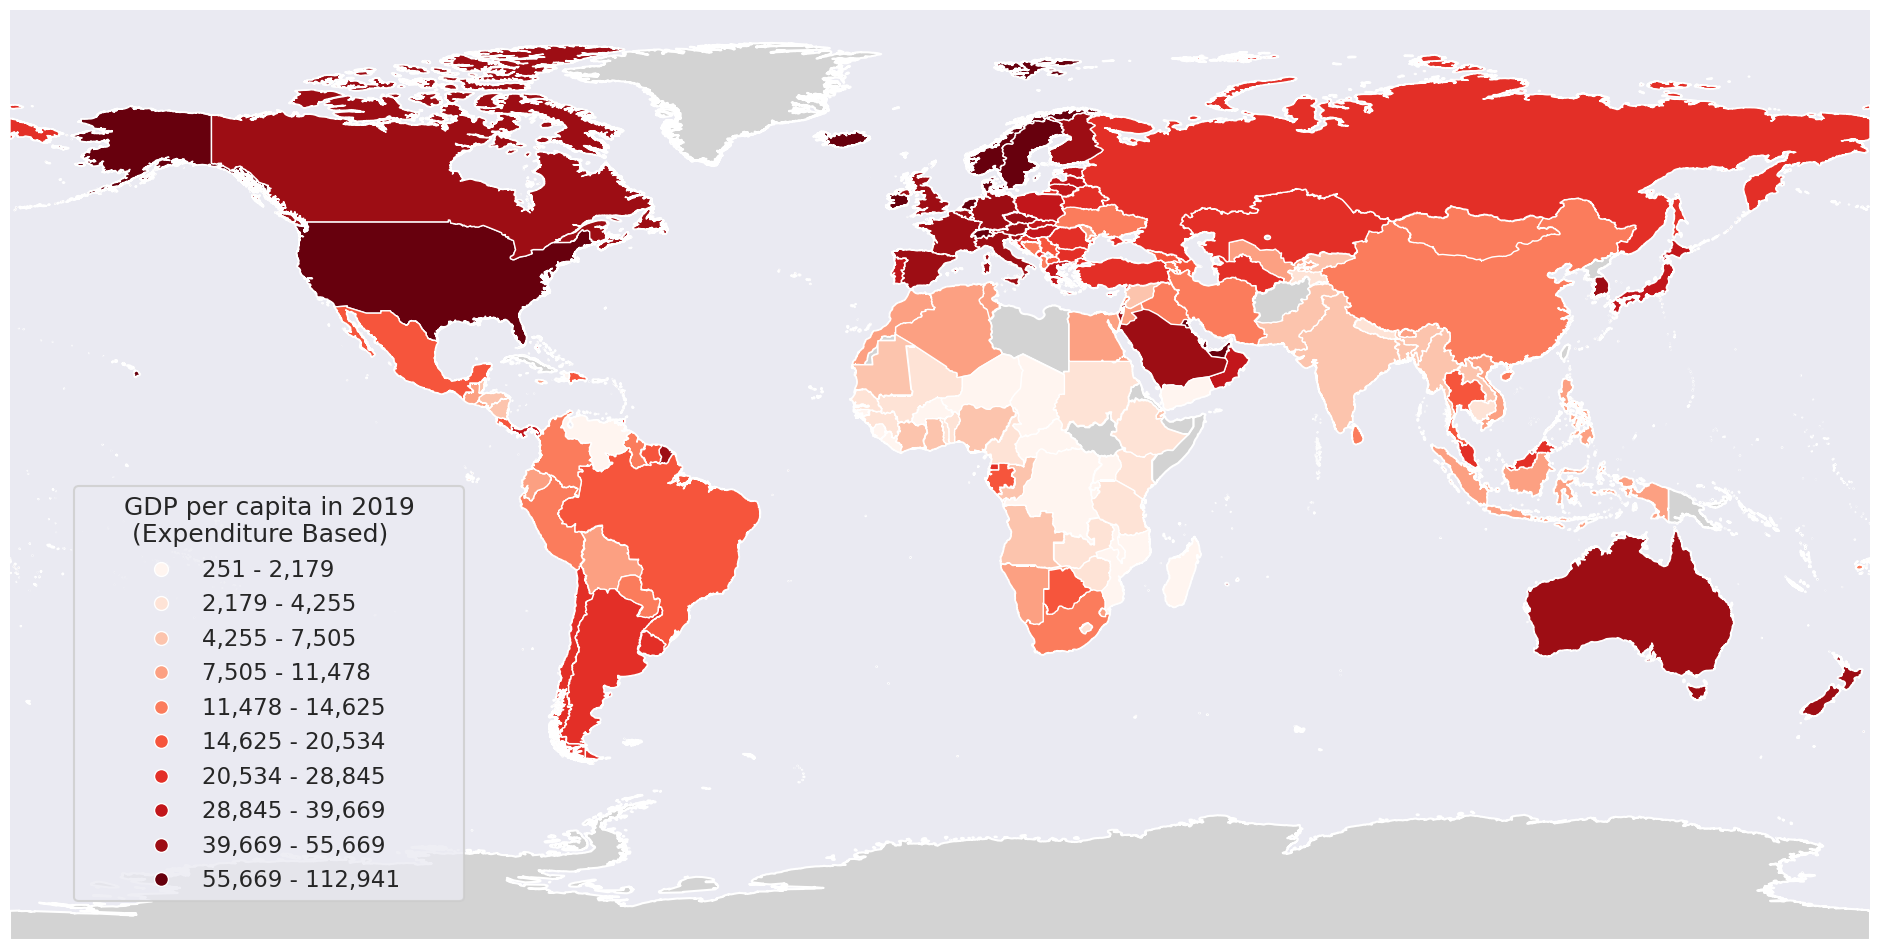

In [68]:
mylegend = center_wrap(["GDP per capita in " + str(year), "(Expenditure Based)"], cwidth=32, width=32)
MyChloropleth(dffig2, myfile='fig-gdp-pc-' + str(year) + '-pwt', myvar='gdp_pc_e', mylegend=mylegend, k=10, scheme='Quantiles', save=False)

# Quick and Easy Maps with
<center><a href="https://plotly.com/python/"><img src="https://raw.githubusercontent.com/SMU-Econ-Growth/EconGrowthUG-Notebooks/main/pics/plot_ly-ar21.svg" alt="plotly express" width=700/></a></center>

In [69]:
url = 'https://plotly.com/python/maps/'
IFrame(url, width=800, height=400)

# Map using classes (similar to **geoplot**)

## Choose a classifier and classify the data

In [70]:
scheme = mc.Quantiles(dffig2['gdp_pc_e'], k=5)
classifier = mc.Quantiles.make(k=5, rolling=True)
dffig2['gdp_pc_q'] = classifier(dffig2['gdp_pc_e'])
dffig2['gdp_pc_qc'] = dffig2['gdp_pc_q'].apply(lambda x: scheme.get_legend_classes()[x].replace('[   ', '[').replace('( ', '('))

In [71]:
fig = px.choropleth(dffig2.sort_values('gdp_pc_q', ascending=True), 
                    locations="iso3c",
                    color="gdp_pc_qc",
                    hover_name='name',
                    hover_data=['iso3c', 'ln_pop', 'gdp_pc_o', 'gdp_pc_e'],
                    labels={
                        "gdp_pc_qc": "GDP per capita (" + str(year) + ") Range",
                        'iso3c':'ISO code',
                        "ln_pop": "Log[Population (" + str(year) + ")]",
                        "ln_gdp_pc_o": "Log[GDP per capita (" + str(year) + ")] (Output Based)",
                        "ln_gdp_pc_e": "Log[GDP per capita (" + str(year) + ")] (Expenditure Based)",
                        "gdp_pc_o": "GDP per capita (" + str(year) + ") (Output Based)",
                        "gdp_pc_e": "GDP per capita (" + str(year) + ") (Expenditure Based)",
                    },
                    color_discrete_sequence=px.colors.sequential.Reds,
                    height=600, 
                    width=1100,
                   )
# Change legend position
fig.update_layout(legend=dict(
    yanchor="bottom",
    y=0.15,
    xanchor="left",
    x=0.05
))

In [72]:
fig.show()

In [73]:
fig = px.choropleth(dffig2.sort_values('gdp_pc_q', ascending=True), 
                    locations="iso3c",
                    color="gdp_pc_qc",
                    hover_name='name',
                    hover_data=['iso3c', 'ln_pop', 'gdp_pc_o', 'gdp_pc_e'],
                    labels={
                        "gdp_pc_qc": "GDP per capita (" + str(year) + ") Range",
                        'iso3c':'ISO code',
                        "ln_pop": "Log[Population (" + str(year) + ")]",
                        "ln_gdp_pc_o": "Log[GDP per capita (" + str(year) + ")] (Output Based)",
                        "ln_gdp_pc_e": "Log[GDP per capita (" + str(year) + ")] (Expenditure Based)",
                        "gdp_pc_o": "GDP per capita (" + str(year) + ") (Output Based)",
                        "gdp_pc_e": "GDP per capita (" + str(year) + ") (Expenditure Based)",
                    },
                    color_discrete_sequence=px.colors.sequential.Blues,
                    height=600, 
                    width=1100,
                   )
# Change legend position
fig.update_layout(legend=dict(
    yanchor="bottom",
    y=0.15,
    xanchor="left",
    x=0.05
))

In [74]:
fig.show()

In [75]:
fig = px.choropleth(dffig,
                    locations="iso3c",
                    color="ln_gdp_pc_e",
                    hover_name='name',
                    hover_data=['iso3c', 'ln_pop', 'gdp_pc_o', 'gdp_pc_e'],
                    labels={
                        "gdp_pc_qc": "GDP per capita (" + str(year) + ") Range",
                        'iso3c':'ISO code',
                        "ln_pop": "Log[Population (" + str(year) + ")]",
                        "ln_gdp_pc_o": "Log[GDP per capita (" + str(year) + ")] (Output Based)",
                        "ln_gdp_pc_e": "Log[GDP per capita (" + str(year) + ")] (Expenditure Based)",
                        "gdp_pc_o": "GDP per capita (" + str(year) + ") (Output Based)",
                        "gdp_pc_e": "GDP per capita (" + str(year) + ") (Expenditure Based)",
                    },
                    #color_continuous_scale=px.colors.sequential.Plasma,
                    color_continuous_scale="Reds",
                    height=800, 
                    width=1100,
                   )

In [76]:
fig.show()

In [77]:
fig.update_layout(coloraxis_colorbar=dict(
    orientation = 'h',
    yanchor="bottom", 
    xanchor="left", 
    y=-.01,
    x=0,
))
fig.update_coloraxes(colorbar_title_side='top')

In [78]:
fig.show()

In [79]:
# Change legend position
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="center",
    x=0.01,
    orientation='h',
))

In [80]:
fig.show()

In [81]:
fig = go.Figure(data=go.Choropleth(
    locations = dffig['iso3c'],
    z = dffig['gdp_pc_e'],
    text = dffig['name'],
    colorscale = 'Blues',
    autocolorscale=False,
    reversescale=True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_tickprefix = '$',
    colorbar_title = 'GDP pc',
    )                  
)
fig.update_layout(
    autosize=False,
    width=800,
    height=400,
    margin=dict(
        l=5,
        r=5,
        b=10,
        t=10,
        pad=1
    ),
    paper_bgcolor="LightSteelBlue",
)

In [82]:
fig.show()

In [83]:
fig = go.Figure(data=go.Choropleth(
    locations = dffig['iso3c'],
    z = dffig['gdp_pc_e'],
    text = dffig['name'],
    colorscale = 'Blues',
    autocolorscale=False,
    reversescale=True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_tickprefix = '$',
    colorbar_title = 'GDP per capita',
    )                  
)
fig.update_layout(
    autosize=False,
    width=1000,
    height=600,
    margin=dict(
        l=1,
        r=1,
        b=1,
        t=1,
        pad=.1
    ),
    paper_bgcolor="LightSteelBlue",
)
# Change legend position
cb = fig.data[0].colorbar
cb.orientation = 'h'
cb.yanchor = 'bottom'
cb.xanchor = 'center'
cb.y = .1
cb.title.side = 'top'

In [84]:
fig.show()

# <center>Exercises</center>

<div class="alert alert-block alert-warning">
    <b>Exercise 1:</b> Use the PWT data on the <b>Capital stock at constant 2017 national prices (in mil. 2017US$), Population, Number of persons engaged (in millions), Human capital index, and Average annual hours worked by persons engaged</b> in each country to create measures of capital per capita <math>K/POP</math>, capital per worker <math>K/L</math>, capital per effective worker <math>K/(h * L)</math>, and capital per unit of effective labor <math>K/(h * time worked * L)</math>. Additionally, construct similar meaures of GDP per capita, worker, per human capital, and unit of effective labor. 
</div>

<div class="alert alert-block alert-warning">
<b>Exercise 2:</b> Using the <code>my_xy_plot</code> function plot the relation between <b>GDP</b> and <b>capital</b> in the aggregate, per capita, per worker, per effective worker, per unit of of effective labor in the years 1950, 1970, 1990, 2010, and the last period available.
</div>

<div class="alert alert-block alert-warning">
<b>Exercise 3:</b> Using the <code>my_xy_line_plot</code> function plot the evolution of <b>GDP</b> and <b>capital</b> for each of these measures by income groups and regions (separate figures).
</div>

<div class="alert alert-block alert-warning">
<b>Exercise 4:</b> Below we have the nice function <code>my_kde_plots_joint</code> that plots the distribution of a variable in different years. Use it to show the evolution of the distribution of log-income per capita and log-capital per worker every 10 years (make sure to include the last year of data)
</div>

In [85]:
def my_kde_plots_joint(dataset='pwt', myyears=[2000, 2020], myvar='gdp_pc_e', myvar_label='Income per capita'):
    '''
    This function plots the KDE-plot of log income per capita in two years, where
    
    dataset: is either pwt or wdi (you need to ensure the variable 'gdp_pc' exists)
    myyears: is a list of years
    '''
    df = eval(dataset + '.loc[' + dataset +'.year.isin(myyears)].copy().reset_index(drop=True)')
    # Plot
    mycolors = sns.color_palette("Paired",n_colors=len(myyears))
    fig, ax = plt.subplots()
    for t in range(len(myyears)):
        sns.kdeplot(df.loc[df.year==myyears[t], myvar], ax=ax, fill=True, label=str(myyears[t]), linewidth=2, color=mycolors[t])
    ax.set_xlabel(myvar_label)
    ax.set_ylabel('Density of Countries')
    ax.legend()
    plt.savefig(pathgraphs + dataset +'_' + myvar + '_' + str(myyears[0]) + '_' + str(myyears[-1]) + '.pdf', dpi=300, bbox_inches='tight')
    plt.savefig(pathgraphs + dataset +'_' + myvar + '_' + str(myyears[0]) + '_' + str(myyears[-1]) + '.png', dpi=300, bbox_inches='tight')
    plt.draw()
    return "Done"

### Example of use: Evolution of distribution Log[Population] using years 2000, 2010, and 2019

'Done'

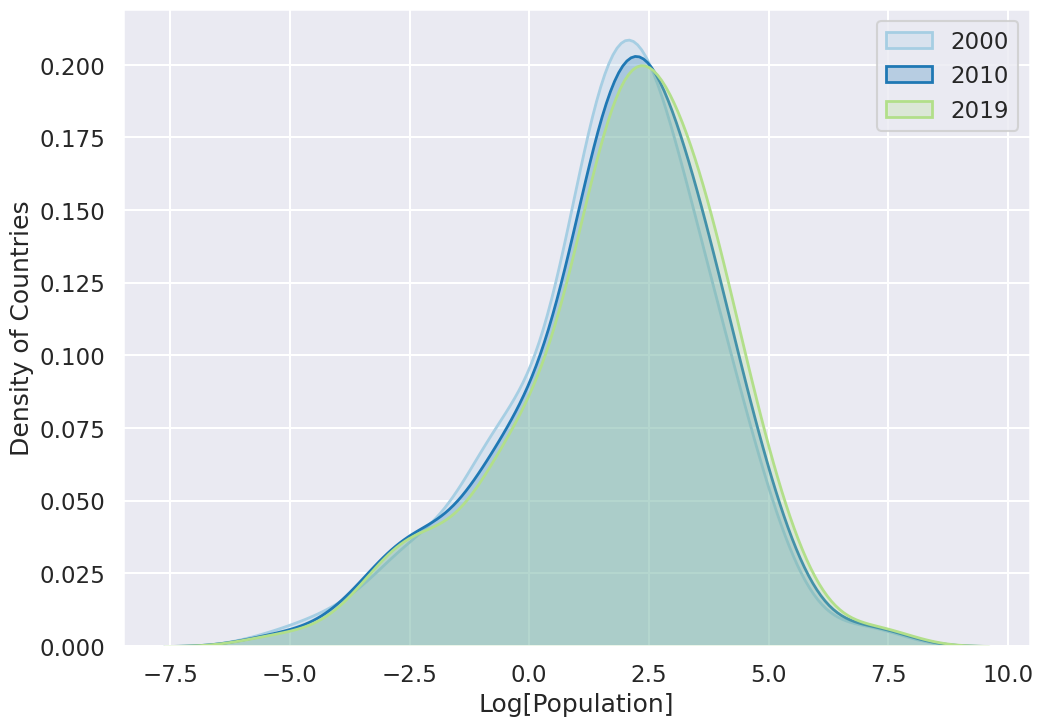

In [86]:
my_kde_plots_joint(dataset='pwt', myyears=[2000, 2010, 2019], myvar='ln_pop', myvar_label='Log[Population]')

<div class="alert alert-block alert-warning">
<b>Exercise 5:</b> Create a static and a dynamic map showing one of the capital measures you created in the year 2015 across the world. 
</div>

<div class="alert alert-block alert-warning">
<b>Exercise 6:</b> For the last year available in the data, explore the relation between each pair of income and capital measures you created above. Consider only relations between these variables at the same level, i.e., both must have been created using the same denomonator. Using one of the various OLS regression models we saw in class, estimate the elasticity between the two measures. Show the relation for all levels of normalization in one nice looking table.
</div>

<div class="alert alert-block alert-warning">
<b>Exercise 7 (Extra Credit):</b> The following code creates a plot that shows the estimated coefficients and the 95% confidence interval for all models. Can you write a function that takes as inputs a list of models, a list of model names, the name of a variable, a label for teh variable, and generates the plot and saves it.
</div>

In [87]:
coefs = []
models = [mod, mod2, mod3, mod4]
model_names = ['Model 1', 'Model 2', 'Model 3', 'Model 4']
for m in range(len(models)):
    coefs2 = pd.concat([models[m].params, models[m].bse, models[m].conf_int()], axis=1).reset_index()
    coefs2.columns = ['variable', 'b', 'se', 'lo', 'hi']
    coefs2['model'] = model_names[m]
    coefs.append(coefs2)
coefs = pd.concat(coefs).reset_index(drop=True)

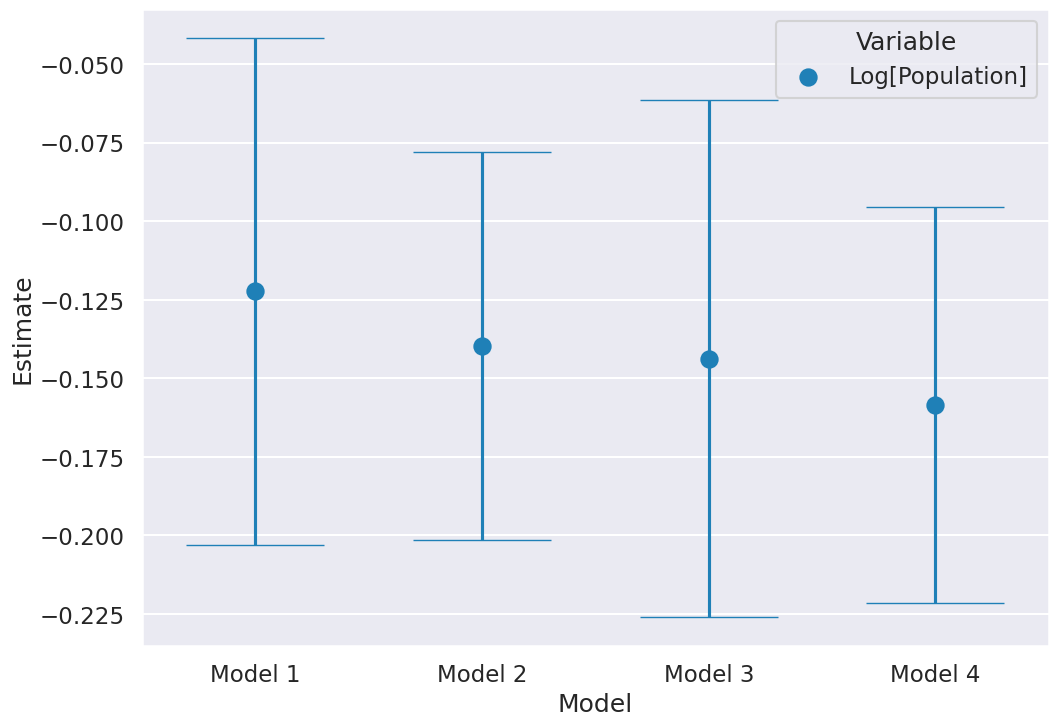

In [88]:
alpha = 0.05
variable = 'ln_pop'
variable_label = 'Log[Population]'
fig, ax = plt.subplots()
ax.errorbar(coefs.loc[coefs.variable==variable].model, 
            coefs.loc[coefs.variable==variable].b, 
            yerr=coefs.loc[coefs.variable==variable].apply(lambda x: norm.ppf(1-alpha/2)*x.se, axis=1), 
            c=sns.color_palette("YlGnBu_d",n_colors=1)[0], capsize=50, fmt='none', label='')
sns.pointplot(data=coefs.loc[coefs.variable==variable], 
              x="model", y="b", hue="variable", 
              capsize=.5, palette="YlGnBu_d", 
              join=False, 
              ax = ax, label=variable_label)
ax.set_xlabel('Model')
ax.set_ylabel('Estimate')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, [variable_label], title='Variable', )

Notebook written by [Ömer Özak](http://omerozak.com) for his students and anyone wanting to learn. Feel free to use, distribute, or contribute.

[<center><img src="https://github.com/measuring-culture/Expanding-Measurement-Culture-Facebook-JRSI/blob/main/pics/SMUlogowWordmarkRB.jpg?raw=true" width="250"></center>](http://omerozak.com)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b928a93e-fd2c-49da-903d-eba3f1d11670' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>